In [1]:
import os
import json
from pathlib import Path
import openai
import pandas as pd
import logging
from IPython.display import clear_output
from copy import deepcopy
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

from parse import parse

from finetuning import prepare_data
from utils import graph
from utils import utils
from nodes.node_functions import *

In [2]:
from utils.utils import get_user_input

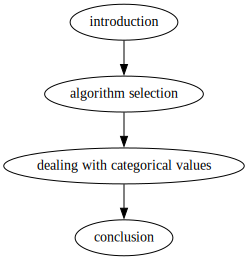

In [2]:
interview_graph = graph.create_interview_flowchart()

graph.plot_graph(interview_graph)

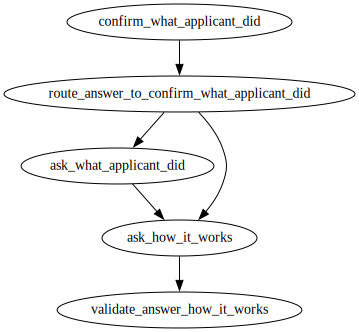

In [3]:
graph.plot_graph(interview_graph.nodes["algorithm selection"]['graph'])

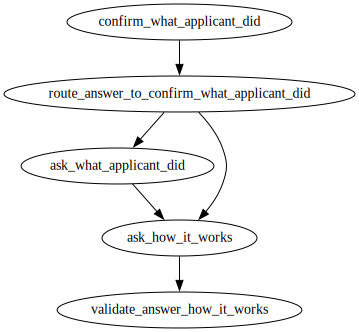

In [4]:
graph.plot_graph(interview_graph.nodes["dealing with categorical values"]['graph'])

In [5]:
def identify_what_applicant_has_done_in_ipynb():
    applicant_approaches = {
        'algorithm selection': 'Decision tree',
        'categorical encoding': 'one hot encoding'
    }
    applicant_approaches_json = json.dumps(applicant_approaches)
    return applicant_approaches_json

what_applicant_has_done_in_ipynb = identify_what_applicant_has_done_in_ipynb()
what_applicant_has_done_in_ipynb

'{"algorithm selection": "Decision tree", "categorical encoding": "one hot encoding"}'

In [13]:
interview_graph.nodes["algorithm selection"]['graph'].nodes['confirm_what_applicant_did']['function_args']['context'] = what_applicant_has_done_in_ipynb
interview_graph.nodes["dealing with categorical values"]['graph'].nodes['confirm_what_applicant_did']['function_args']['context'] = what_applicant_has_done_in_ipynb

In [5]:
# interview_graph.nodes["algorithm selection"]['graph'].nodes['ask_how_it_works']['function_args']['subject'] = "DBSCAN"

In [61]:
# current_node = interview_graph.nodes["dealing with categorical values"]['graph'].nodes["ask_how_it_works"]

# # section_graph = interview_graph.nodes["dealing with categorical values"]['graph']
# # [n for n,d in section_graph.in_degree() if d==0] 

# current_node_function_args = deepcopy(current_node['function_args'])
# current_node_function_args['carryover_data'] = dict(algorithm_selection=dict(subject='Ordinal encoding'))
# current_node_function_args['chat_history_by_section'] = [[]]

# current_node_output = current_node['function'](**current_node_function_args)

In [14]:
# chat

# each list within this variable is the conversation in a particular section. each string within that list is the ordered dialogue from each member of the interview
chat_history_by_section = []
flattened_chat_history = ""

# list of the nodes that have been visited till the current point
sections_visited_names = []
nodes_visited_names = []

validate_async = False

is_interview_complete = False

carryover_data = {
"dealing with categorical values": {
    "ask_how_it_works": {
        "subject": "hash encoding"
    }
},
"algorithm selection": {
    "ask_what_you_did": {
        "subject": ""
    }
}
}

def get_first_node_in_graph(graph):
    first_node_name = [node_name for node_name, in_degrees in graph.in_degree() if in_degrees==0][0]
    first_node = graph.nodes[first_node_name]
    return first_node_name, first_node

def get_next_node(graph, current_node_name, current_node_output):
    outgoing_edges = list(graph.out_edges(current_node_name, data=True))
    if len(outgoing_edges) == 0:
        return None, None
    else:
        if len(outgoing_edges) == 1:
            edge_to_traverse = outgoing_edges[0]
        else:
            for edge in outgoing_edges:
                if current_node_output['routing_value'] in edge[-1]['passthrough_values']:
                    edge_to_traverse = edge
        next_node_name = edge_to_traverse[1]
        next_node = graph.nodes[next_node_name]
        return next_node_name, next_node
    
current_section_name, current_section = get_first_node_in_graph(interview_graph)
current_section_graph = current_section['graph']

In [15]:


# traverse through sections
while not is_interview_complete:
    chat_history_by_section.append([])
    current_node_name, current_node = get_first_node_in_graph(current_section_graph)
    # print("\n\ncurrent section: " + current_section_name)
    # print("current node: " + current_node_name)
    is_section_complete = False
    # traverse within section
    while not is_section_complete:
        # access current node from current section
        # prep args for current node function
        current_node_function_args = deepcopy(current_node['function_args']) if 'function_args' in current_node else {}
        current_node_function_args['current_section_name'] = current_section_name
        # current_node_function_args['current_node_name'] = current_node_name
        current_node_function_args['carryover_data'] = carryover_data
        current_node_function_args['validate_async'] = validate_async
        current_node_function_args['chat_history_by_section'] = chat_history_by_section

        # call function
        current_node_output = current_node['function'](**current_node_function_args)
        
        if current_node_output['new_chat_lines']:
            # store return values in appropriate variables (chat_history)
            chat_history_by_section[-1].extend(current_node_output['new_chat_lines'])
            flattened_chat_history += "\n" + "\n".join(current_node_output['new_chat_lines'])
            clear_output()
            print(flattened_chat_history)
    
        # update nodes_visited
        nodes_visited_names.append(current_node_name)
    
        # figure out next node to visit
        current_node_name, current_node = get_next_node(current_section_graph, current_node_name, current_node_output)
        if current_node_name is None:
            # prepare routing_value (result of a section)
            current_section_output = dict(routing_value=1, 
                                          new_chat_line=None) 
            is_section_complete = True

    
    sections_visited_names.append(current_section_name)
    # get new section
    current_section_name, current_section = get_next_node(interview_graph, current_section_name, current_section_output)
    if current_section_name is None:
        is_interview_complete = True
        break
    current_section_graph = current_section['graph']



Interviewer: Thank you for taking the time out to interview with us. 
    In this interview, we will cover a range of topics and ask questions to assess your skill level as a Data Scientist. 
    If you don't understand a question, feel free to ask questions to get clarification.
    Let's get started.
Interviewer: Could you please confirm whether you used a Decision Tree for this challenge?
Applicant: That's right.
Interviewer: How does a Decision Tree work?
Applicant: It is a set of decision nodes that split the data based on a threshold value for a column. All observations where the column value is lower than the threshold are split to one side, and the rest to the other. More decision nodes are created on those split datasets in a recursive manner, until you get a decision leaf, which gives you the model prediction for all observations that match the path it took to get to the leaf.
Interviewer: I see that you used one hot encoding to encode your categorical values. Could you conf

In [6]:
prepare_data.validate_observations_for_finetuning_from_queue()


******************
********* Model Name *********
route_answer_to_confirm_what_applicant_did
********* Prompt *********
Current section chat:
Interviewer: Based on your submission, I saw that you used forward selection to select your features. Is that correct?
Applicant: That's right. I tried backward selection and lasso as well, but forward selection gave me the best results.

Details:
Is routing correct: 1
###

********* Completion *********
Route: 1
******************



Do you want to validate this observation now? (1/0):  1
Is completion correct? (1/0):  1
Continue validating from queue? (1/0):  1
